In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
path = './input/'
file1_name = path + 'test22_analytical_SEL.txt'
plottitle = file1_name + '; Analytical SEL; Sources: 4135 at 2100psi'
freq_limit = False
low_freq = False
file2_name = path + 'test22_analytical_SEL.txt'

In [3]:
f = open(file1_name)
lines = f.read().splitlines()
f.close()
for i, line in enumerate(lines):
    if i < 30:
        print(i, line)

0 FileType : Sound Exposure Level
1 FileVersion : 5
2 SourceKernel : 2.0
3 Routine : Analytical
4 Geometrical_spread : 2
5 SEL_window_length(ms) : 10500
6 Azimuth_beg : 0
7 Azimuth_end : 0
8 Azimuth_inc : 40
9 Range_beg : 100
10 Range_end : 50000
11 Range_inc : 100
12 Depth_beg : 20
13 Depth_end : 1000
14 Depth_inc : 20
15 Filter_bool : 0
16 Coordinate_system : Cylindrical
17 Sea_WaterAttn : None
18 Notional_name : 4135H__080_2100_080
19 
20 Azimuth:deg  Range:m  Depth:m  SEL:dB re 1uPa^2 s  
21 0            100      20       183.475             
22 0            100      40       187.414             
23 0            100      60       188.83              
24 0            100      80       189.53              
25 0            100      100      189.69              
26 0            100      120      189.409             
27 0            100      140      188.93              
28 0            100      160      188.375             
29 0            100      180      187.817             


In [4]:
df = pd.DataFrame()

In [5]:
column_names = ['Azimuth', 'Range', 'Depth', 'SEL']

In [6]:
if freq_limit:
    rowstoskip = 26
    #minval = 120
    minval = 80
    maxval = 170
    if low_freq:
        minval = 80
        #minval = 130
        maxval = 190
else:
    rowstoskip = 21
    #minval = 80
    minval = 130
    maxval = 190

In [7]:
df = pd.read_csv(file1_name, names=column_names, skiprows=rowstoskip, delim_whitespace=True)

In [8]:
df.drop(['Azimuth'], axis=1, inplace=True)

In [9]:
len(df)

25000

In [10]:
df_reverse = pd.read_csv(file2_name, names=column_names, skiprows=rowstoskip, delim_whitespace=True)
df_reverse.drop(['Azimuth'], axis=1, inplace=True)

In [11]:
df_pivot = df.pivot(index='Depth', columns='Range', values='SEL')

In [12]:
#df_pivot

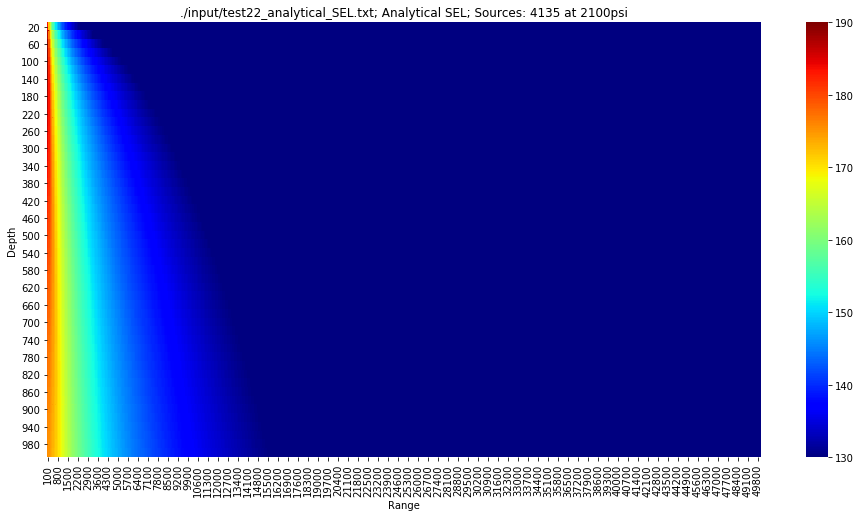

In [13]:
plt.figure(figsize=(16,8))
plt.title(plottitle)
sns.heatmap(df_pivot, cmap='jet', vmin=minval, vmax=maxval)
plt.savefig('1.png'); 

In [14]:
#df

In [15]:
#def mirror_data(data):
#    data_temp = data[['Range']]
#    data_temp_sort = data_temp.sort_values(by=['Range'], ascending=False).reset_index(drop=True)
#    data = data.join(data_temp_sort, rsuffix='-mirror') 
#    return data
    

In [16]:
#data_mirror = mirror_data(df)

In [17]:
#data_mirror

In [18]:
def data_mirror_zero(data):
    data_negative = data.copy(deep=True)
    data_zero_offset = data.loc[data['Range'] == 100].reset_index(drop=True)
    data_zero_offset['Range'] = 0
    #print(data_zero_offset)
    data_negative['Range'] = data_negative['Range'].apply(np.negative)
    data_negative_sort = data_negative.sort_values(by=['Range','Depth'])#.reset_index(drop=True)
    combined_data = pd.concat([data_negative_sort, data_zero_offset, data]).reset_index(drop=True)
    return combined_data

In [19]:
df_mirror = data_mirror_zero(df)

In [20]:
df_reverse_mirror = data_mirror_zero(df_reverse)

In [21]:
df_mirror_pivot = df_mirror.pivot(index='Depth', columns='Range', values='SEL')

In [22]:
df_mirror_pivot.columns

Int64Index([-50000, -49900, -49800, -49700, -49600, -49500, -49400, -49300,
            -49200, -49100,
            ...
             49100,  49200,  49300,  49400,  49500,  49600,  49700,  49800,
             49900,  50000],
           dtype='int64', name='Range', length=1001)

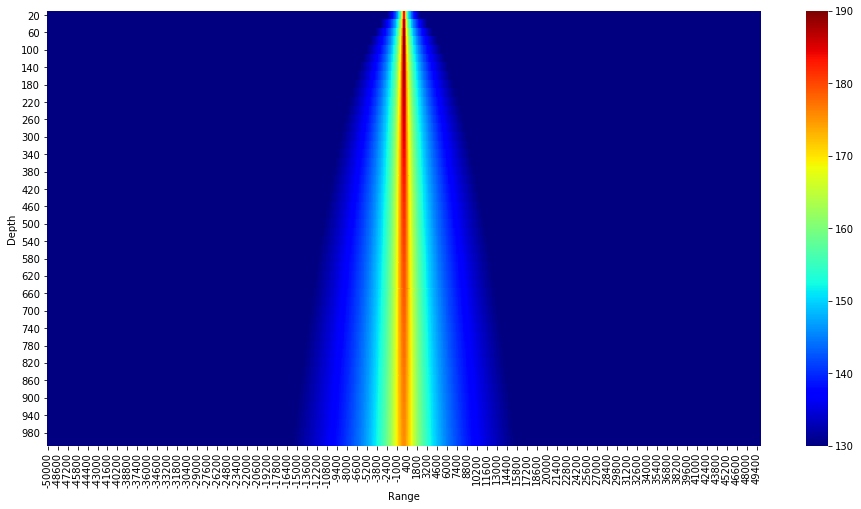

In [23]:
plt.figure(figsize=(16,8))
sns.heatmap(df_mirror_pivot, cmap='jet', vmin=minval, vmax=maxval); 

In [24]:
def shift_and_limit(data, shift, minval, maxval):
    data['Range'] = data['Range'] + shift
    data_limit = data.loc[(data['Range'] >= minval) & (data['Range'] <= maxval)].reset_index(drop=True)
    return data_limit

In [25]:
df_mirror_shift = shift_and_limit(df_mirror, 10000, 100, 50000)

In [26]:
df_mirror_shift_pivot = df_mirror_shift.pivot(index='Depth', columns='Range', values='SEL')

In [27]:
#df_mirror_shift_pivot

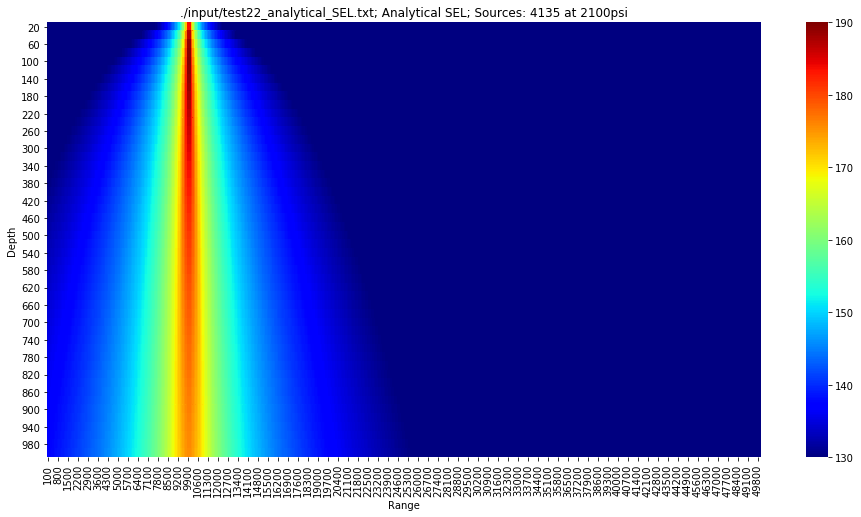

In [28]:
plt.figure(figsize=(16,8))
plt.title(plottitle)
sns.heatmap(df_mirror_shift_pivot, cmap='jet', vmin=minval, vmax=maxval)
plt.savefig('2.png'); 

In [29]:
len(df_mirror_shift)

25000

In [30]:
#df_merge = df.merge(df_mirror_shift, left_on='Range', right_on='Range')
df_merged = df.join(df_mirror_shift, rsuffix='-shift')    

In [31]:
#df_merged

In [32]:
def dB_sum(amp1, amp2):
    x = amp1/10
    y = amp2/10
    amp_comb = 10*np.log10(10**x + 10**y)
    return amp_comb 

In [33]:
print(dB_sum(182.568, 145.683))

182.56888969228777


In [34]:
df_merged['SEL_sum'] = df_merged.apply(lambda x: dB_sum(x.SEL, x['SEL-shift']), axis=1)

In [35]:
#df_merged

In [36]:
df_merged_pivot = df_merged.pivot(index='Depth', columns='Range', values='SEL_sum')

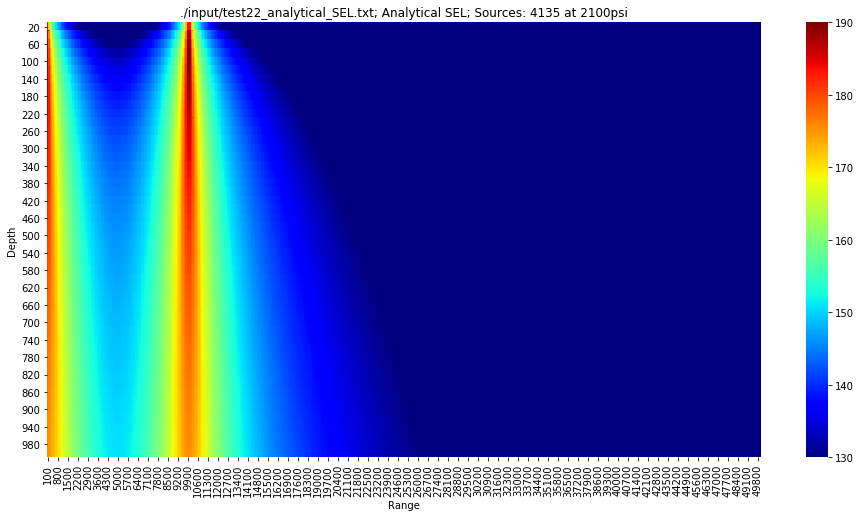

In [37]:
plt.figure(figsize=(16,8))
plt.title(plottitle)
sns.heatmap(df_merged_pivot, cmap='jet', vmin=minval, vmax=maxval)
plt.savefig('3.png'); 

In [38]:
#df_SI = shift_and_limit(df_mirror, 40000, 100, 50000)

In [39]:
df_SI = shift_and_limit(df_reverse_mirror, 50000, 100, 50000)

In [40]:
df_SI_pivot = df_SI.pivot(index='Depth', columns='Range', values='SEL')

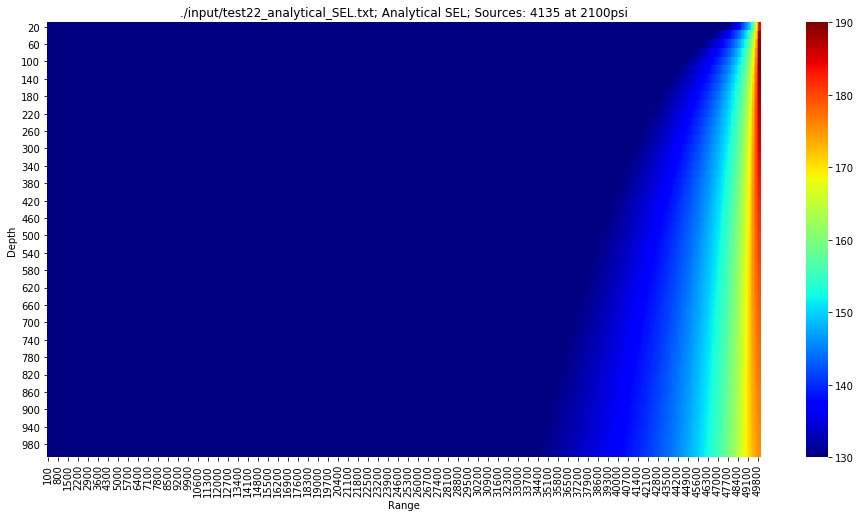

In [41]:
plt.figure(figsize=(16,8))
plt.title(plottitle)
sns.heatmap(df_SI_pivot, cmap='jet', vmin=minval, vmax=maxval)
plt.savefig('4.png'); 

In [42]:
df_SI_merged = df.join(df_SI, rsuffix='-shift') 

In [43]:
df_SI_merged['SEL_sum'] = df_SI_merged.apply(lambda x: dB_sum(x.SEL, x['SEL-shift']), axis=1)

In [44]:
df_SI_merged_pivot = df_SI_merged.pivot(index='Depth', columns='Range', values='SEL_sum')

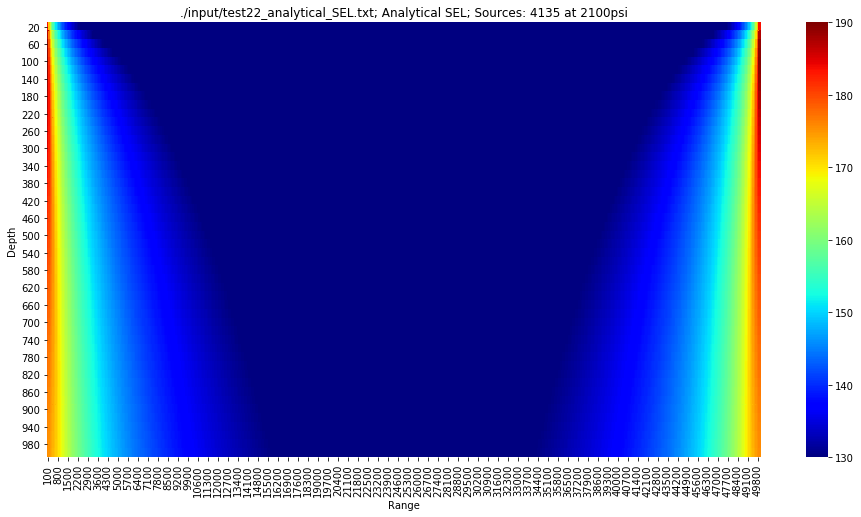

In [45]:
plt.figure(figsize=(16,8))
plt.title(plottitle)
sns.heatmap(df_SI_merged_pivot, cmap='jet', vmin=minval, vmax=maxval)
plt.savefig('5.png'); 

In [46]:
#df_merged

In [47]:
df_CLO_SI_merged = df_merged.join(df_SI, rsuffix='-shift2')

In [48]:
df_CLO_SI_merged['SEL_SI_CLO_sum'] = df_CLO_SI_merged.apply(lambda x: dB_sum(x.SEL_sum, x['SEL-shift2']), axis=1)

In [49]:
df_CLO_SI_merged_pivot = df_CLO_SI_merged.pivot(index='Depth', columns='Range', values='SEL_SI_CLO_sum')

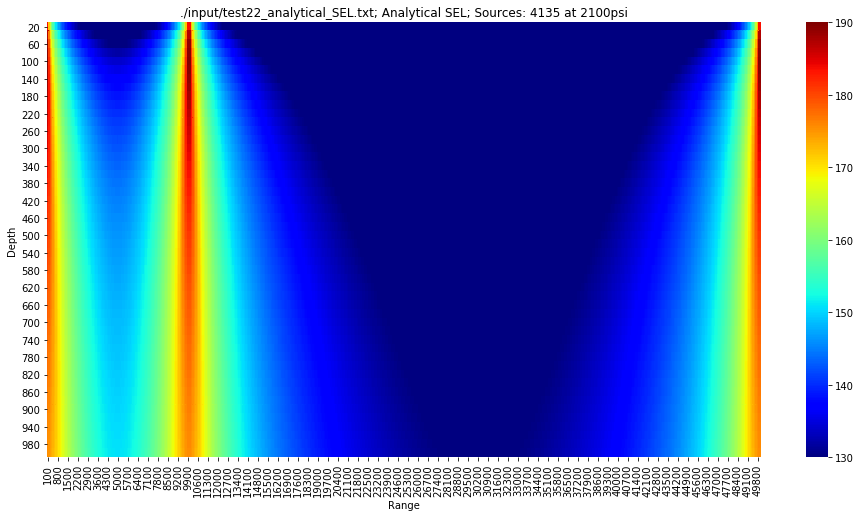

In [50]:
plt.figure(figsize=(16,8))
plt.title(plottitle)
sns.heatmap(df_CLO_SI_merged_pivot, cmap='jet', vmin=minval, vmax=maxval)
plt.savefig('6.png'); 

In [51]:
df_CLO_SI_merged_shallow = df_CLO_SI_merged.loc[df_CLO_SI_merged['Depth'] == 20].reset_index(drop=True)
df_SI_merged_shallow = df_SI_merged.loc[df_SI_merged['Depth'] == 20].reset_index(drop=True)
df_merged_shallow = df_merged.loc[df_merged['Depth'] == 20].reset_index(drop=True)
df_shallow = df.loc[df['Depth'] == 20].reset_index(drop=True)

In [52]:
sns.set_style("darkgrid")
sns.set_context("notebook")

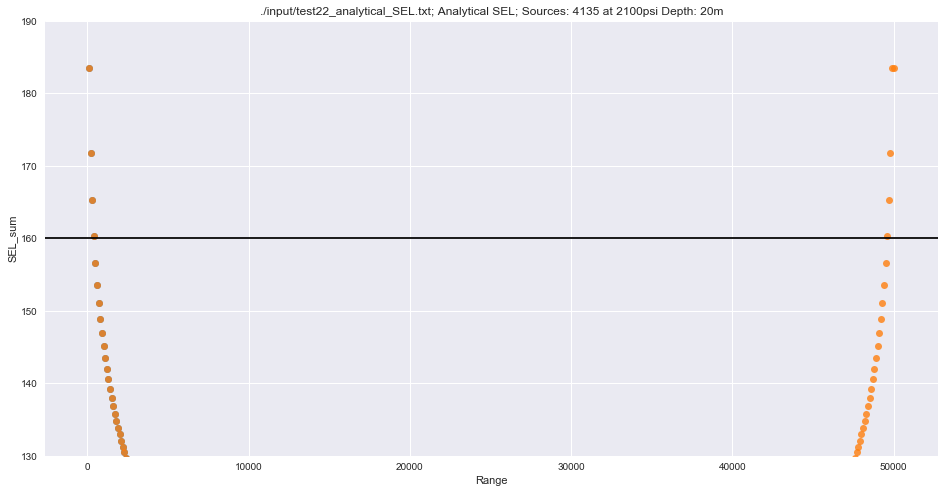

In [53]:
plt.figure(figsize=(16,8))
plt.title(plottitle + ' Depth: 20m')
plt.axhline(160, color='black')
plt.ylim(minval, maxval)
sns.regplot(x=df_shallow['Range'], y=df_shallow['SEL'], fit_reg=False)
#sns.regplot(x=df_merged_shallow['Range'], y=df_merged_shallow['SEL_sum'], fit_reg=False)
sns.regplot(x=df_SI_merged_shallow['Range'], y=df_SI_merged_shallow['SEL_sum'], fit_reg=False)
#sns.regplot(x=df_CLO_SI_merged_shallow['Range'], y=df_CLO_SI_merged_shallow['SEL_SI_CLO_sum'], fit_reg=False)
plt.savefig('7.png'); 

In [54]:
df_CLO_SI_merged_middepth = df_CLO_SI_merged.loc[df_CLO_SI_merged['Depth'] == 1000].reset_index(drop=True)
df_SI_merged_middepth = df_SI_merged.loc[df_SI_merged['Depth'] == 1000].reset_index(drop=True)
df_merged_middepth = df_merged.loc[df_merged['Depth'] == 1000].reset_index(drop=True)
df_middepth = df.loc[df['Depth'] == 1000].reset_index(drop=True)

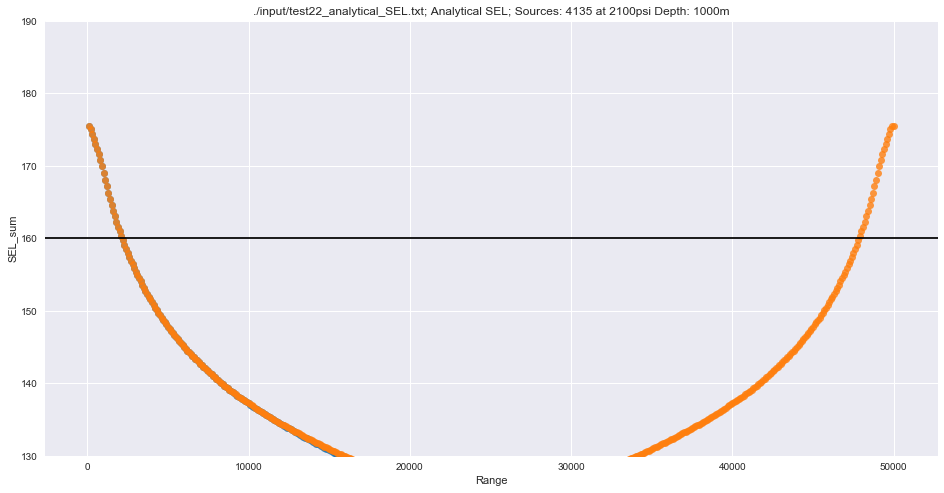

In [55]:
plt.figure(figsize=(16,8))
plt.title(plottitle + ' Depth: 1000m')
plt.axhline(160, color='black')
plt.ylim(minval, maxval)
sns.regplot(x=df_middepth['Range'], y=df_middepth['SEL'], fit_reg=False)
#sns.regplot(x=df_merged_middepth['Range'], y=df_merged_middepth['SEL_sum'], fit_reg=False)
sns.regplot(x=df_SI_merged_middepth['Range'], y=df_SI_merged_middepth['SEL_sum'], fit_reg=False)
#sns.regplot(x=df_CLO_SI_merged_middepth['Range'], y=df_CLO_SI_merged_middepth['SEL_SI_CLO_sum'], fit_reg=False)
plt.savefig('8.png'); 